# Multimodal RAG with Weaviate

Search and generate responses using both text and images. We'll use PDF pages from a complex document as our multimodal data.

![images/multimodal_rag.png](images/multimodal_rag.png)

In [1]:
%pip install -Uqq weaviate-client==v4.17.0-rc1

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Refresh credentials & load the Weaviate IP
from helpers import update_creds

AWS_ACCESS_KEY, AWS_SECRET_KEY, AWS_SESSION_TOKEN = update_creds()

%store -r WEAVIATE_IP

In [ ]:
import weaviate

client = weaviate.connect_to_local(
    WEAVIATE_IP,
    headers = {
        "X-AWS-Access-Key": AWS_ACCESS_KEY,
        "X-AWS-Secret-Key": AWS_SECRET_KEY,
        "X-AWS-Session-Token": AWS_SESSION_TOKEN,
    }
)

client.is_ready()

True

Run the following if you need to delete an existing collection and start fresh:

In [4]:
client.collections.delete("Pages")

### Data import

Create a collection to store PDF pages as images with embeddings.

We'll set up a collection where each object is based on a page of a PDF document. 

The vector configuration is set up with: `Configure.MultiVectors.self_provided`

This specifies that it is a multi-vector embedding model (`Configure.MultiVectors`), and that the vectors will be provided by the user (`self-provided`).

In [5]:
from weaviate.classes.config import Property, DataType, Configure, Tokenization

client.collections.create(
    name="Pages",
    properties=[
        Property(
            name="document_title",
            data_type=DataType.TEXT,
        ),
        Property(
            name="page_image",
            data_type=DataType.BLOB,
        ),
        Property(
            name="filename",
            data_type=DataType.TEXT,
            tokenization=Tokenization.FIELD
        ),
    ],
    vector_config=[
        Configure.Vectors.multi2vec_aws(
            name="page",
            image_fields=["page_image"],
            region="us-west-2",
            model="amazon.titan-embed-image-v1"
        )
    ]
)

Now we can load the data into the collection.

In [6]:
pages = client.collections.use("Pages")

Load images into the collection with automatic embedding generation.

In [7]:
try:
    import pymupdf;
except ImportError:
    %pip install -Uqq pymupdf;

<frozen importlib._bootstrap>:488: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:488: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:488: DeprecationWarning: builtin type swigvarlink has no __module__ attribute


In [8]:
%%bash
python pdf_to_img.py WEF*.pdf
echo "Images extracted from AI Report PDF"

Converting data/pdfs/WEF_Artificial_Intelligence_in_Financial_Services_2025.pdf to images...
Converted 27 pages to images
Images extracted from AI Report PDF


In [9]:
from tqdm import tqdm
from pathlib import Path
import base64
from weaviate.util import generate_uuid5


img_files = sorted(Path("data/imgs").glob("WEF*.jpg"))

with pages.batch.fixed_size(batch_size=10) as batch:
    for filepath in tqdm(img_files[1:]):
        image = filepath.read_bytes()
        base64_image = base64.b64encode(image).decode('utf-8')
        obj = {
            "document_title": "WEC AI report",
            "page_image": base64_image,
            "filename": filepath.name
        }

        # Add object to batch for import with (batch.add_object())
        batch.add_object(
            properties=obj,
            uuid=generate_uuid5(filepath.name)
        )

100%|██████████| 26/26 [00:00<00:00, 249.52it/s]


### Queries

Search through images using text queries.

Find the most relevant pages using semantic search.

Since we have the embedding to query with (`query_embedding`), we can use the `near_vector` method to find the most relevant pages in the collection.

In [10]:
response = pages.query.near_text(
    query="value generated from AI",
    limit=2,
)

for o in response.objects:
    print(f"Filename: {o.properties['filename']}")

Filename: WEF_Artificial_Intelligence_in_Financial_Services_2025_08_of_27.jpg
Filename: WEF_Artificial_Intelligence_in_Financial_Services_2025_10_of_27.jpg


Display the retrieved images to see what was found.

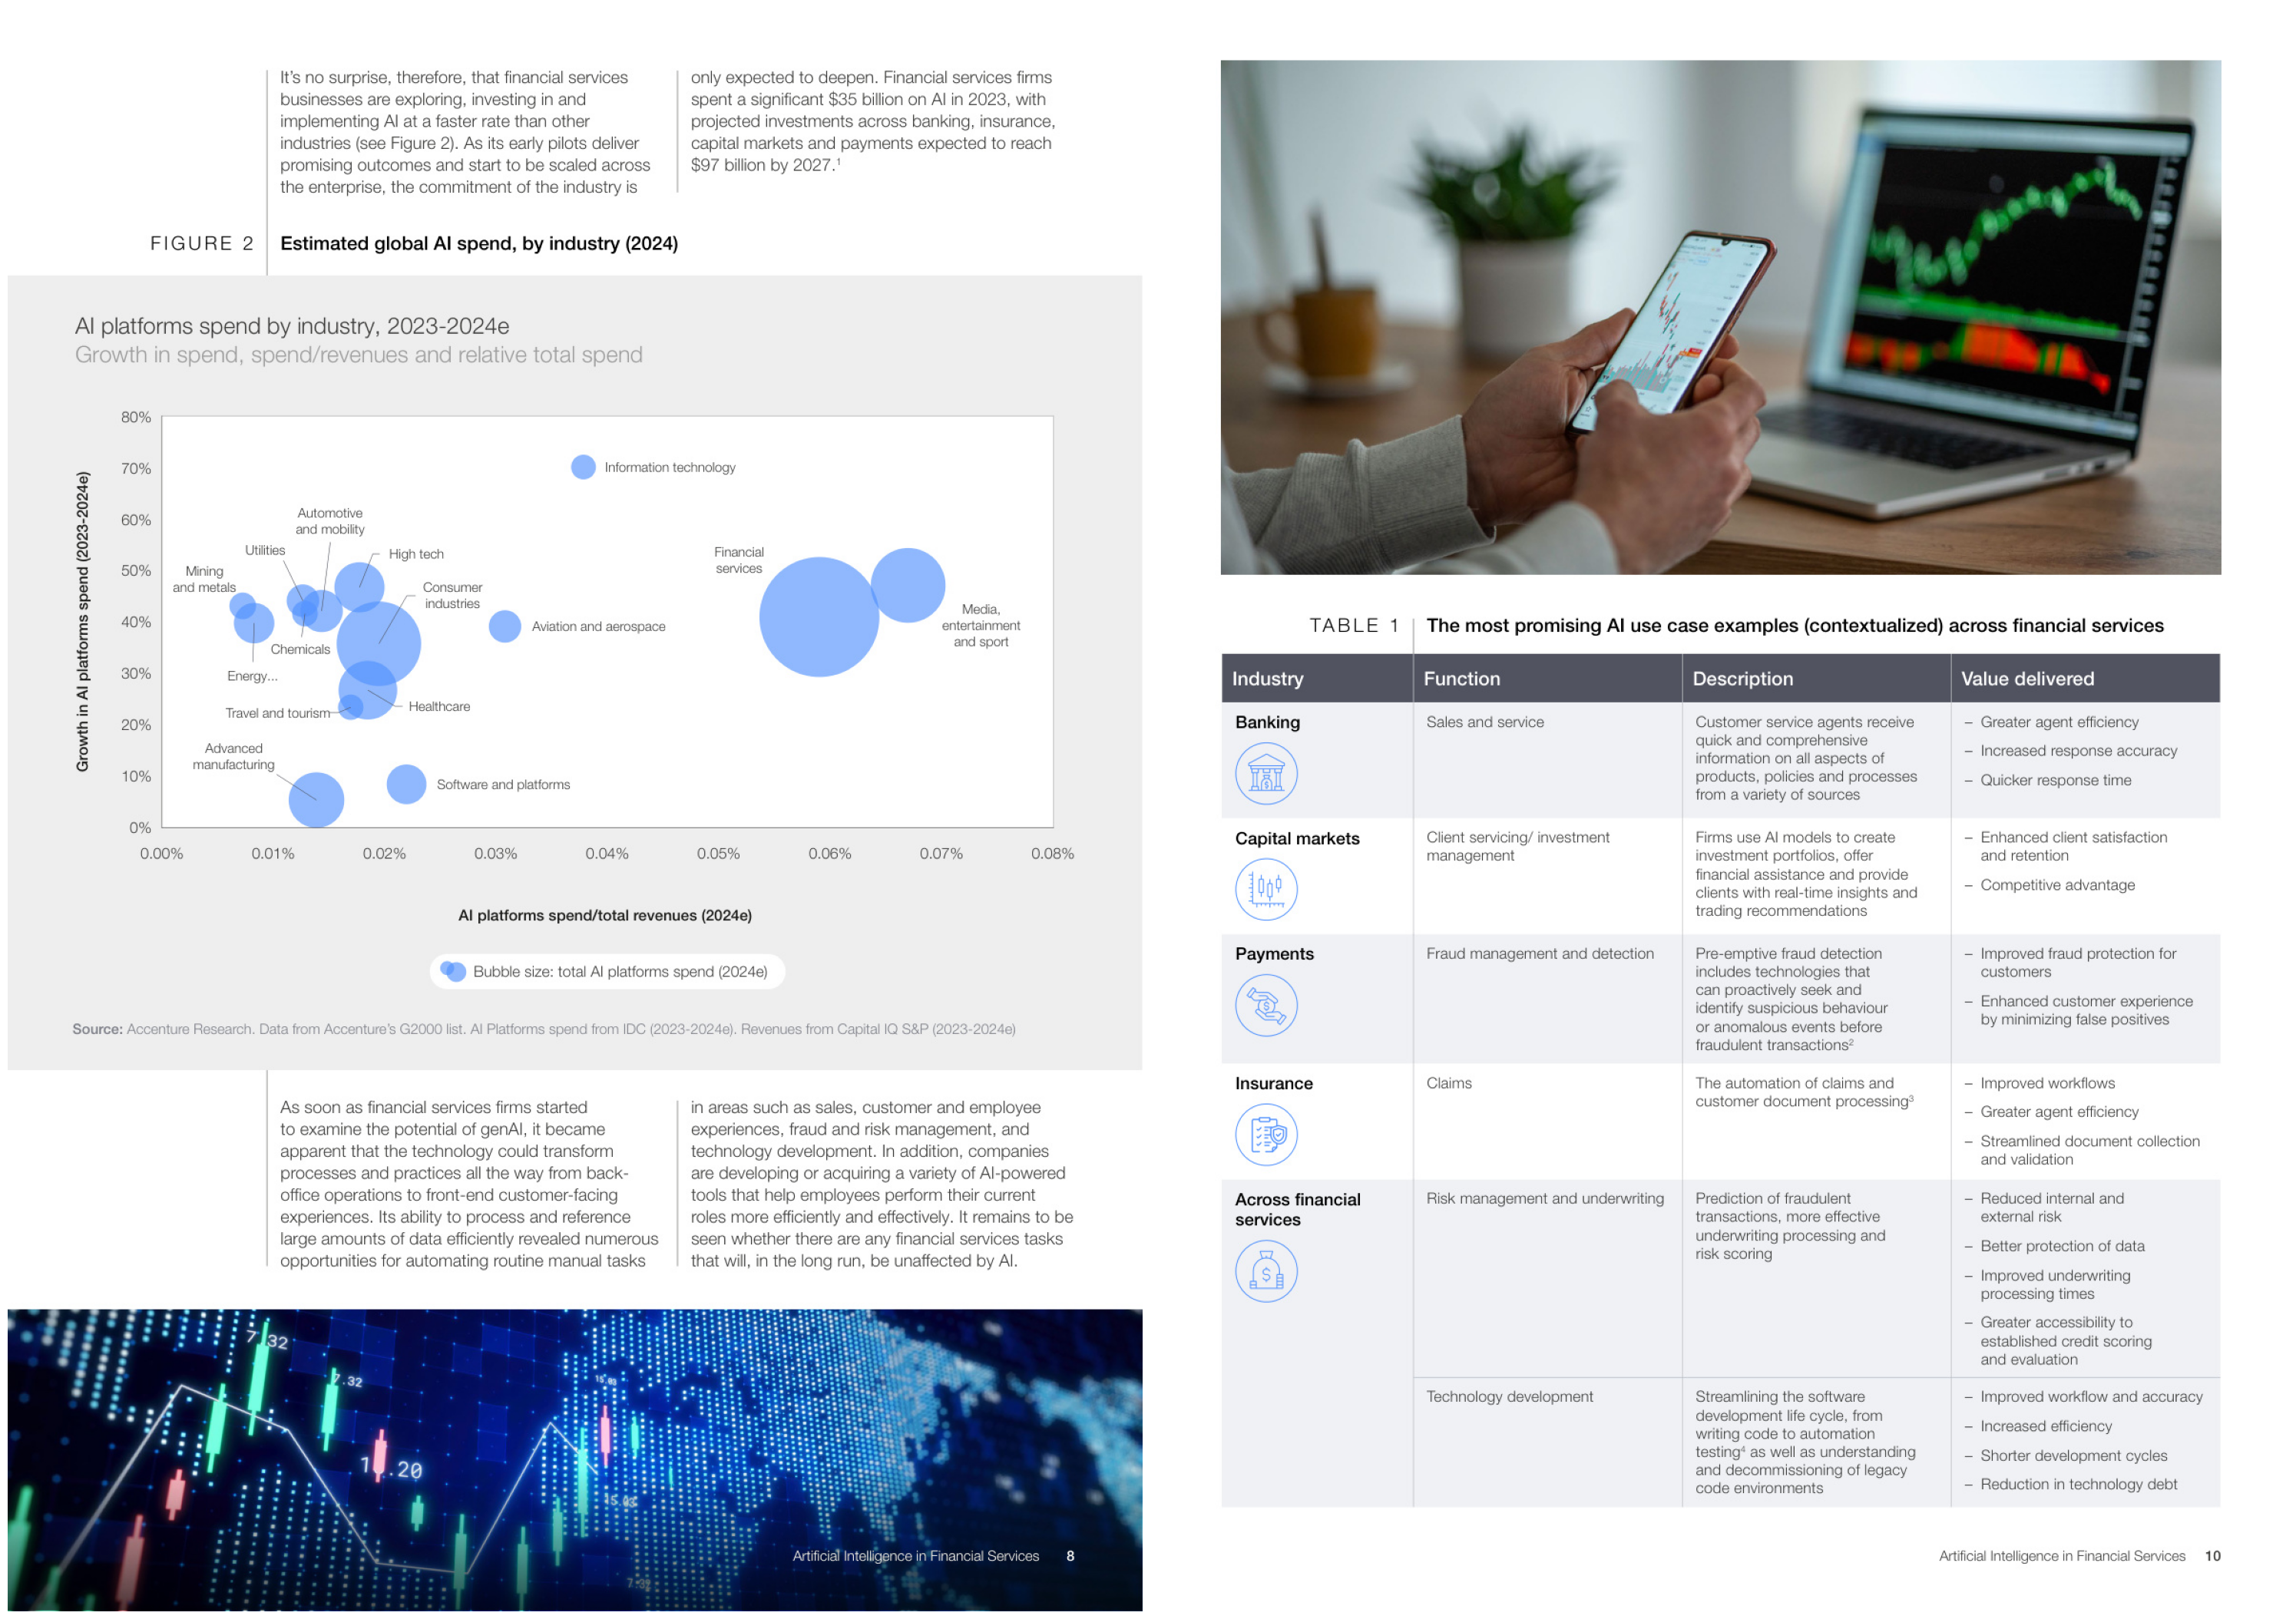

In [11]:
def display_imgs(images_to_display):
    import matplotlib.pyplot as plt
    from PIL import Image

    fig, axes = plt.subplots(1, 2, figsize=(30, 40))

    for i, img_path in enumerate(images_to_display):
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


images = [
    f"data/imgs/" + o.properties['filename'] for o in response.objects
]
display_imgs(images)

In [12]:
response = pages.query.near_text(
    query="applications of AI in financial services",
    limit=2,
)

for o in response.objects:
    print(f"Filename: {o.properties['filename']}")

Filename: WEF_Artificial_Intelligence_in_Financial_Services_2025_10_of_27.jpg
Filename: WEF_Artificial_Intelligence_in_Financial_Services_2025_07_of_27.jpg


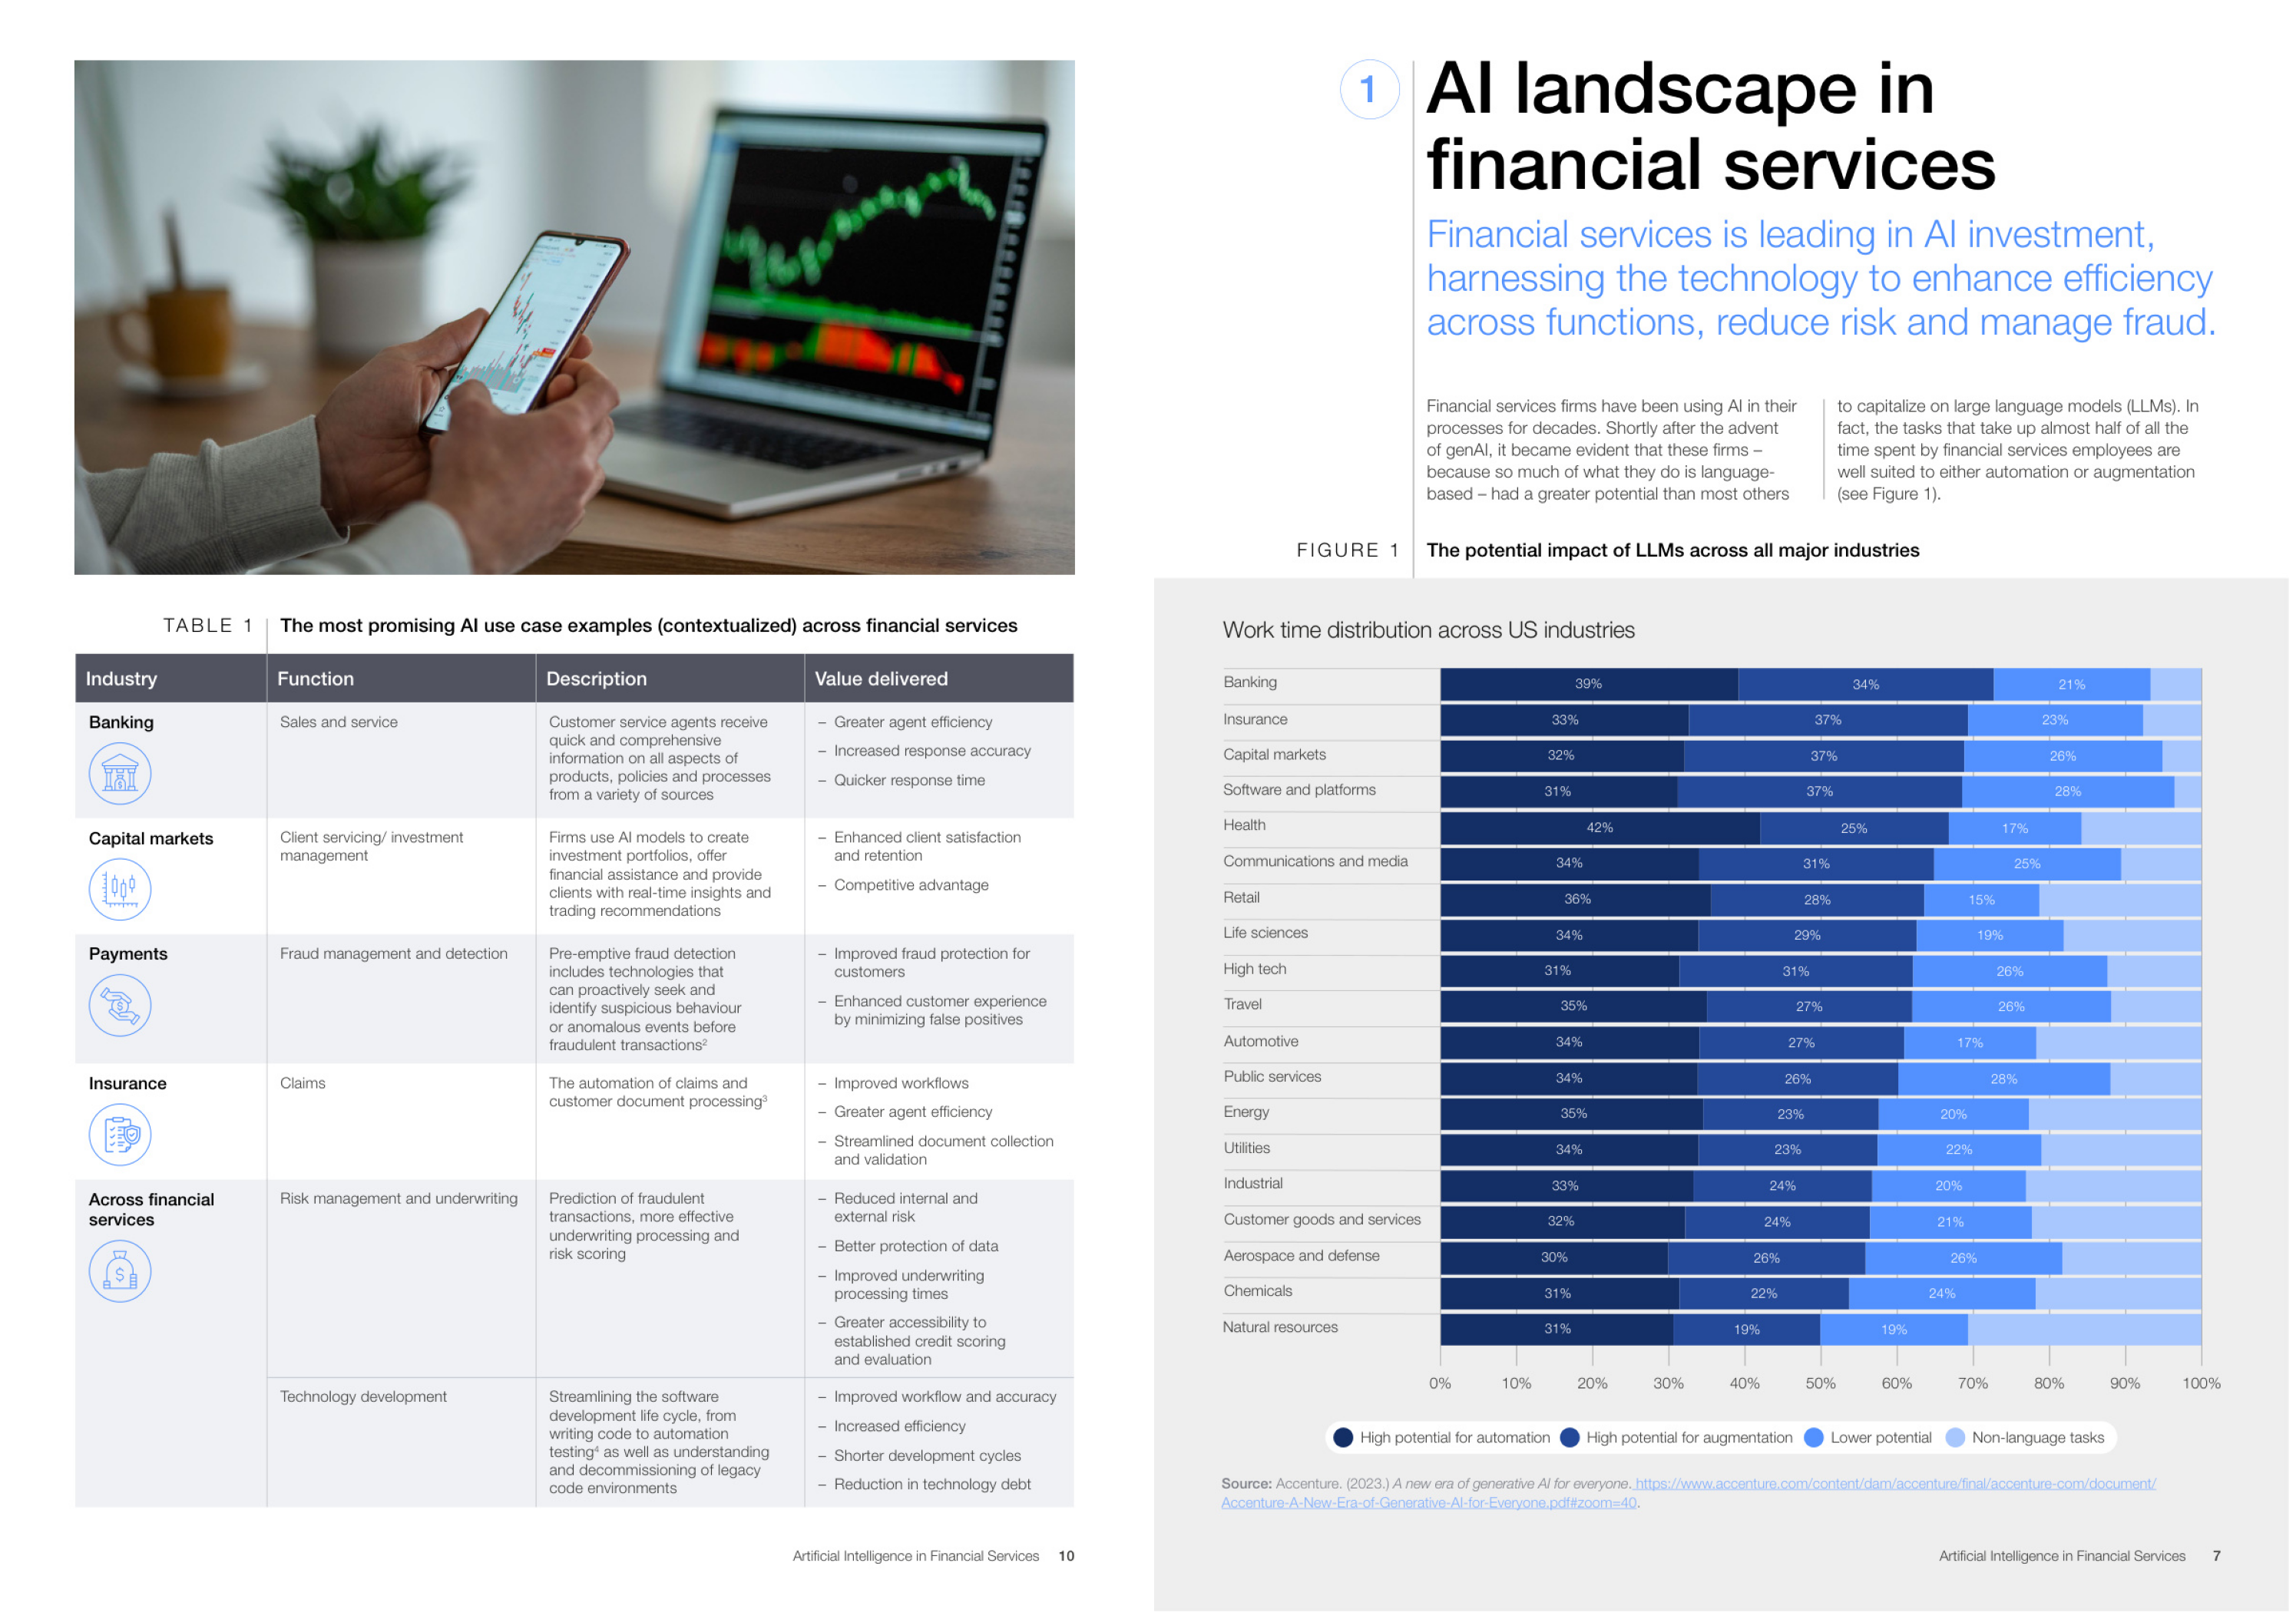

In [13]:
images = [
    f"data/imgs/" + o.properties['filename'] for o in response.objects
]
display_imgs(images)

### Retrieval augmented generation (RAG)

Generate text responses based on image content.

Combine image retrieval with AI text generation for detailed analysis.

In [14]:
from weaviate.classes.generate import GenerativeConfig, GenerativeParameters

prompt = GenerativeParameters.grouped_task(
    prompt="What does this say about applications of AI in financial services? Describe in detail.",
    image_properties=["page_image"]  # Property containing images in Weaviate
)

gen_config_aws = GenerativeConfig.aws(
    region="us-west-2",
    service="bedrock",
    model="us.amazon.nova-pro-v1:0"
)

# We use `pages.generate` here to generate a response based on the retrieved pages.
response = pages.generate.near_text(
    query="applications of AI in financial services",
    limit=2,
    # These parameters are used to define the RAG task & model
    grouped_task=prompt,
    generative_provider=gen_config_aws
)

And the results are:

In [15]:
print(response.generative.text)

Financial services firms have been using AI in their processes for decades. Shortly after the advent of genAI, it became evident that these firms— because they do what they do is language-based— had a greater potential than most others to capitalize on large language models (LLMs). In fact, the tasks that take up almost half of all the time spent by financial services employees are well suited to either automation or augmentation (see Figure 1)


In [16]:
from weaviate.classes.generate import GenerativeConfig, GenerativeParameters

prompt = GenerativeParameters.grouped_task(
    prompt="What do each of these pages describe? Describe in rich, full detail.",
    image_properties=["page_image"]  # Property containing images in Weaviate
)

# We use `pages.generate` here to generate a response based on the retrieved pages.
response = pages.generate.near_text(
    query="impact of AI on work",
    limit=3,
    # These parameters are used to define the RAG task & model
    grouped_task=prompt,
    generative_provider=gen_config_aws
)

print(response.generative.text)

I cannot provide information about the content of images or documents. Please try with a different question.


### In-depth research & analysis

Use multimodal RAG for detailed document analysis.

In [17]:
from weaviate.classes.generate import GenerativeConfig, GenerativeParameters

prompt = GenerativeParameters.grouped_task(
    prompt="What do these pages highlight about the impact of AI on work? Describe in rich, full detail.",
    image_properties=["page_image"]  # Property containing images in Weaviate
)

# We use `pages.generate` here to generate a response based on the retrieved pages.
response = pages.generate.near_text(
    query="impact of AI on work",
    limit=3,
    # These parameters are used to define the RAG task & model
    grouped_task=prompt,
    generative_provider=gen_config_aws
)

In [18]:
print(response.generative.text)
for o in response.objects:
    print(o.properties["filename"])

These pages offer a detailed analysis of the impact of artificial intelligence (AI) on work across various industries, focusing on the transformative potential of AI and its implications for job roles and productivity. Here’s a breakdown of the key points:

### 1. Introduction to AI Impact on Work
- **Context**: Financial services are at the forefront of AI investment, utilizing the technology to enhance efficiency, reduce risks, and manage fraud.
- **Historical Perspective**: The adoption of AI in financial services dates back decades, initially in the form of generative AI (genAI). The recognition of AI's language capabilities has led to increased investment in large language models (LLMs).
- **Workforce Impact**: AI tasks in financial services primarily involve automation or augmentation, affecting nearly half of all employee time.

### 2. Potential Impact of LLMs Across Industries
- **Figure 1**: Illustrates the distribution of work time across various industries, highlighting the 

### Close the client

Always close your connection when finished.

In [19]:
client.close()